In [1]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import torch

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [2]:
import torch
import numpy as np

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000


In [5]:
import pathlib
import urllib.request
import zipfile
import os

# Define the data directory path
data_dir = pathlib.Path('data/maestro-v2.0.0')

# Check if the data directory exists, if not, download and extract the dataset
if not data_dir.exists():
    # URL of the dataset
    url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'
    
    # Download the dataset
    zip_path = pathlib.Path('data/maestro-v2.0.0-midi.zip')
    if not zip_path.exists():
        print("Downloading the dataset...")
        urllib.request.urlretrieve(url, zip_path)
    
    # Extract the ZIP file
    print("Extracting the dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Remove the ZIP file after extraction
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists.")


Extracting the dataset...
Dataset downloaded and extracted successfully.


In [6]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [7]:
sample_file = filenames[1]
print(sample_file)

data\maestro-v2.0.0\2008\MIDI-Unprocessed_03_R1_2008_01-04_ORIG_MID--AUDIO_03_R1_2008_wav--1.midi


In [8]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [9]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [10]:
display_audio(pm)

In [11]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [12]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=73, note_name=C#5, duration=0.3021
1: pitch=72, note_name=C5, duration=0.2174
2: pitch=70, note_name=A#4, duration=0.1680
3: pitch=69, note_name=A4, duration=0.1471
4: pitch=46, note_name=A#2, duration=0.7578
5: pitch=70, note_name=A#4, duration=0.3372
6: pitch=65, note_name=F4, duration=0.2852
7: pitch=66, note_name=F#4, duration=0.3099
8: pitch=63, note_name=D#4, duration=0.2826
9: pitch=58, note_name=A#3, duration=1.6302


In [14]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [15]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,73,1.070312,1.372396,0.000000,0.302083
1,46,1.088542,1.846354,0.018229,0.757812
2,72,1.277344,1.494792,0.188802,0.217448
3,70,1.484375,1.652344,0.207031,0.167969
4,69,1.673177,1.820312,0.188802,0.147135


In [16]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['C#5', 'A#2', 'C5', 'A#4', 'A4', 'A#4', 'A#3', 'F4', 'F#4', 'D#4'],
      dtype='<U3')

In [17]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

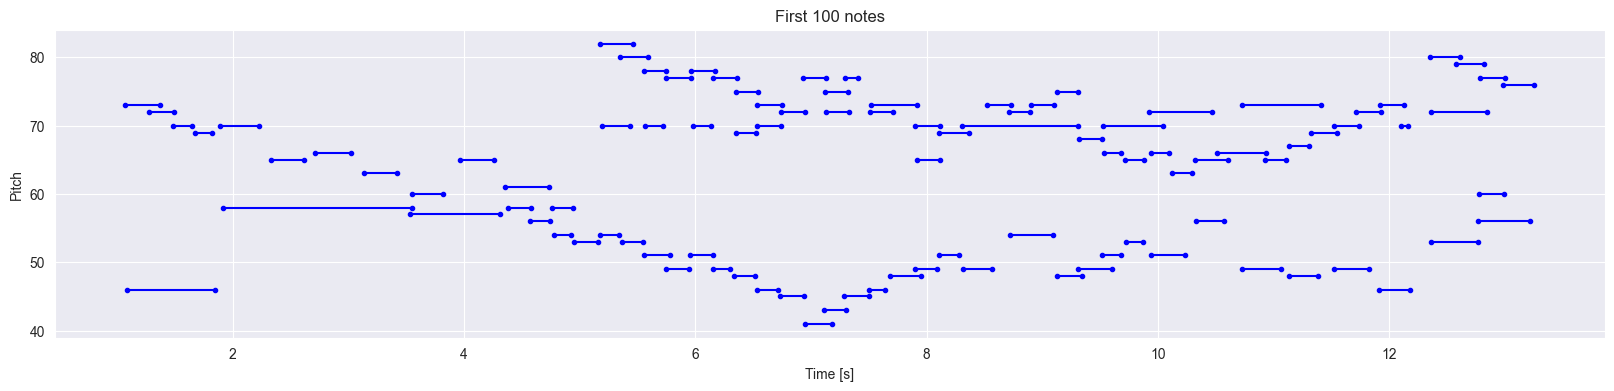

In [18]:
plot_piano_roll(raw_notes, count=100)

In [19]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [20]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [51]:
display_audio(example_pm)

In [22]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [23]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 12982


In [24]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Assuming `train_notes` is a NumPy array or a tensor
train_notes_tensor = torch.tensor(train_notes, dtype=torch.float32)

# Create a TensorDataset from the tensor
notes_ds = TensorDataset(train_notes_tensor)


# Optionally, use DataLoader for batching, shuffling, etc.
notes_loader = DataLoader(notes_ds, batch_size=32, shuffle=True)


In [48]:
from torch.utils.data import Dataset


class SequenceDataset(Dataset):
    def __init__(self, data_tensor, seq_length, vocab_size=128):
        self.data = data_tensor  # Expecting data already as a tensor
        self.seq_length = seq_length + 1
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.data) - self.seq_length + 1

    def __getitem__(self, idx):
        # Get the sequence
        sequence = self.data[idx:idx + self.seq_length]

        # Normalize note pitch
        sequence[:, 0] /= self.vocab_size

        # Split into input and label
        inputs = sequence[:-1]
        labels_dense = sequence[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return inputs, labels

def create_sequences(data_tensor, seq_length, vocab_size=128):
    """Returns a PyTorch Dataset of sequence and label examples."""
    return SequenceDataset(data_tensor, seq_length, vocab_size)

In [49]:

# Assuming notes_ds is a TensorDataset
train_notes_tensor = notes_ds.tensors[0]  # Get the underlying tensor

# Create the sequence dataset
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(train_notes_tensor, seq_length, vocab_size)

# Create a DataLoader to iterate through the dataset
data_loader = DataLoader(seq_ds, batch_size=1, shuffle=False)

# Iterate through the DataLoader and print the first sequence and target
for seq, target in data_loader:
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0, :10])
    print()
    print('target:', target)
    break  # Only take the first example

sequence shape: torch.Size([1, 25, 3])
sequence elements (first 10): tensor([[0.0034, 0.0000, 0.2122],
        [0.0038, 0.0000, 0.2122],
        [0.0037, 0.0026, 0.2005],
        [0.0042, 0.3503, 0.1445],
        [0.0041, 0.1146, 0.1289],
        [0.0042, 0.1302, 0.0299],
        [0.0044, 0.2943, 0.0586],
        [0.0038, 0.2891, 0.1159],
        [0.0042, 0.2812, 0.0365],
        [0.0038, 0.3034, 0.3021]])

target: {'pitch': tensor([0.0037]), 'step': tensor([0.2956]), 'duration': tensor([0.0365])}


In [50]:
import torch
from torch.utils.data import DataLoader, RandomSampler

# Assuming `n_notes` and `seq_length` are defined
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset

# Use RandomSampler for shuffling the dataset
sampler = RandomSampler(seq_ds, replacement=False)

# Create a DataLoader with the specified options
train_loader = DataLoader(
    seq_ds,
    batch_size=batch_size,
    sampler=sampler,  # This handles the shuffling
    drop_last=True,  # Equivalent to drop_remainder=True in TensorFlow
    num_workers=1,  # Parallel data loading, adjust based on your system
    # pin_memory=True,  # Keep data in pinned memory for faster transfer to GPU
    # prefetch_factor=2,  # Number of batches to prefetch
)

# Example: Iterate over the DataLoader and inspect batch shapes
for seq_batch, target_batch in train_loader:
    print('Batch sequence shape:', seq_batch.shape)
    print('Batch target shape:', target_batch)
    break  # Only print the first batch


RuntimeError: DataLoader worker (pid(s) 1972) exited unexpectedly